# Predicting Game Outcomes in the NFL

Our group has chosen to analyze a set of data centered around National Football League (NFL) games that includes betting and weather data. We are interested in seeing if we can produce a model untilizing this betting information and weather data to determine if we can predict, with some accuracy, the outcomes of said games. Our data comes from a [kaggle site](https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data) that centers around utilizing the data in a similar fashion. We are also looking at encorporating a data set from the popular political and sports journalism site, FiveThirtyEight. This data set is structured very similar and contains even more games (dating back to 1920, whereas the kaggle data set goes back to 1966). It provides us an ELO score, which is meant to help produce probabilities a particular team will win a particular game. That data and an explanation of ELO can be found on their [github](https://github.com/fivethirtyeight/nfl-elo-game).

For this milestone, we have chosen to first do our univariate analysis on the kaggle data. As we move forward in our case study, we'll look at encorporating the FiveThirtyEight data as well as conducting multivariate analysis.

## Table of Contents

- [Loading and Cleaning the Data](#load)
    - [Selecting Timeframe](#timeframe)
    - [Dealing With Nulls](#nulls)
- [Univariate Visualizations](#vis)
    - [Correlation Matrix](#cormat)
- [Initial Conclusions](#conclusions)

### Loading & Summarizing the Data <a name="load"></a>

The initial data should be available in the /GroupProducts/ folder and there should be three files:

- spreadspoke_scores.csv
- nfl_stadiums.csv
- nfl_teams.csv

The spreadspoke_scores file will have our betting and weather data, while nfl_stadiums contains information about the location of each stadium in the spreadspoke_scores and the nfl_teams file contains information on each team. For our univariate analysis, we're going to loko at just the spreadspoke_scores data so that way we can get an idea of what our betting and weather data looks like. We can also look at the nfl_stadiums data in order to check what elevation the stadium is at.

In [1]:
#Loading our data and looking at a few rows
betting_df <- data.frame(read.csv("../Data/spreadspoke_scores.csv"))
head(betting_df,1)
tail(betting_df,1)

schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
09/02/1966,1966,1,FALSE,Miami Dolphins,14,23,Oakland Raiders,,NA,NA,Orange Bowl,FALSE,83,6,71,


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
12411,02/03/2019,2018,Superbowl,TRUE,New England Patriots,13,3,Los Angeles Rams,NE,-2,55.5,Mercedes-Benz Stadium,TRUE,72,0,,DOME


In [2]:
max(betting_df$schedule_season)
min(betting_df$schedule_season)

[1] 2018

[1] 1966

### Selecting Timeframe <a name="timeframe"></a>
The kaggle data contains records of games and outcomes from between 1966 to last season (2018). The games then should run from about August/September of 1966 to roughly February of 2019, when the last superbowl was played.

In the NFL and especially in sports reporting, it is common to compare statistics for players and teams across eras. The NFL as we know it today was originally split into multiple leagues. The two most prominent of these were the AFL and the former NFL. These two major leagues merged in 1969, created two conferences within the NFL called the American Football Conference (AFC) and the National Footabll Conference (NFC). This is also when the superbowl came to be. Anything after the 1969 season (so 1970 season and onwards) is termed "the Superbowl Era." 

Additionally, there have been several teams who have joined the league in the superbowl era. As such the league, and number of games played, as grown and changed. The last time a team joined the league was prior to the 2002 season and as such between 2002 and the present is known as "the Modern era."

In order for us to build a well trained model, we've decided to limit our data to just the Superbowl Era. This will allow us to look at teams and games that are the most similar. As such, we'll limit our betting_df to records with a schedule_season of 1970 or greater.

In [3]:
super_bowl_era <- betting_df[which(betting_df$schedule_season >= 1970),]
head(super_bowl_era)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
729,09/18/1970,1970,1,FALSE,Los Angeles Rams,34,13,St. Louis Cardinals,,NA,NA,Los Angeles Memorial Coliseum,FALSE,63,10,84,
730,09/19/1970,1970,1,FALSE,New York Giants,16,24,Chicago Bears,,NA,NA,Yankee Stadium,FALSE,71,13,70,
731,09/20/1970,1970,1,FALSE,Boston Patriots,27,14,Miami Dolphins,,NA,NA,Harvard Stadium,FALSE,66,12,64,
732,09/20/1970,1970,1,FALSE,Buffalo Bills,10,25,Denver Broncos,,NA,NA,War Memorial Stadium,FALSE,63,7,72,
733,09/20/1970,1970,1,FALSE,Cincinnati Bengals,31,21,Oakland Raiders,,NA,NA,Cinergy Field,FALSE,74,10,58,
734,09/20/1970,1970,1,FALSE,Green Bay Packers,0,40,Detroit Lions,,NA,NA,Lambeau Field,FALSE,66,12,75,


In [4]:
#Looking at the structure of our dataframe
str(super_bowl_era)

'data.frame':	11683 obs. of  17 variables:
 $ schedule_date      : Factor w/ 2300 levels "01/01/1967","01/01/1978",..: 459 476 494 494 494 494 494 494 494 494 ...
 $ schedule_season    : int  1970 1970 1970 1970 1970 1970 1970 1970 1970 1970 ...
 $ schedule_week      : Factor w/ 24 levels "1","10","11",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ schedule_playoff   : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ team_home          : Factor w/ 41 levels "Arizona Cardinals",..: 22 27 5 6 9 14 24 26 30 32 ...
 $ score_home         : int  34 16 27 10 31 0 27 3 7 7 ...
 $ score_away         : int  13 24 14 25 21 40 10 14 17 19 ...
 $ team_away          : Factor w/ 41 levels "Arizona Cardinals",..: 36 8 23 12 29 13 19 2 11 15 ...
 $ team_favorite_id   : Factor w/ 34 levels "","ARI","ATL",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ spread_favorite    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ over_under_line    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ stadium            : Factor w/ 105 levels "Alamo Dome","Allte

In [5]:
#summary for our numeric columns
summary(super_bowl_era[,c('score_home','score_away','spread_favorite','over_under_line','weather_temperature','weather_wind_mph')])

   score_home      score_away    spread_favorite   over_under_line
 Min.   : 0.00   Min.   : 0.00   Min.   :-26.500   Min.   :28.00  
 1st Qu.:14.00   1st Qu.:13.00   1st Qu.: -7.000   1st Qu.:38.00  
 Median :21.00   Median :19.00   Median : -4.500   Median :41.50  
 Mean   :22.33   Mean   :19.48   Mean   : -5.369   Mean   :41.84  
 3rd Qu.:29.00   3rd Qu.:27.00   3rd Qu.: -3.000   3rd Qu.:45.00  
 Max.   :62.00   Max.   :62.00   Max.   :  0.000   Max.   :63.50  
                                 NA's   :1755      NA's   :1826   
 weather_temperature weather_wind_mph
 Min.   :-6.00       Min.   : 0.000  
 1st Qu.:48.00       1st Qu.: 3.000  
 Median :62.00       Median : 8.000  
 Mean   :58.87       Mean   : 7.779  
 3rd Qu.:72.00       3rd Qu.:11.000  
 Max.   :97.00       Max.   :40.000  
 NA's   :303         NA's   :303     

In [8]:
#summary for our factor columns
summary(super_bowl_era[,c('team_home','team_away','team_favorite_id','stadium','weather_humidity','weather_detail')])

                team_home                  team_away    team_favorite_id
 San Francisco 49ers : 413   Pittsburgh Steelers: 406          :1755    
 Dallas Cowboys      : 412   Dallas Cowboys     : 403   PIT    : 449    
 Pittsburgh Steelers : 411   Green Bay Packers  : 400   NE     : 432    
 Denver Broncos      : 405   Minnesota Vikings  : 400   DEN    : 424    
 New England Patriots: 405   New York Jets      : 397   DAL    : 417    
 Miami Dolphins      : 403   Washington Redskins: 397   SF     : 415    
 (Other)             :9234   (Other)            :9280   (Other):7791    
              stadium     weather_humidity          weather_detail
 Giants Stadium   : 531          :3778                     :9117  
 Lambeau Field    : 395   74     : 255     DOME            :2334  
 Arrowhead Stadium: 381   72     : 237     Rain            : 106  
 Soldier Field    : 376   76     : 232     DOME (Open Roof):  56  
 Qualcomm Stadium : 375   70     : 223     Fog             :  28  
 Candlestick P

In [9]:
#loading our stadiums data and printing out a few rows
stadiums_df <- data.frame(read.csv("../Data/nfl_stadiums.csv"))
head(stadiums_df)

stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
Alamo Dome,"San Antonio, TX",NA,NA,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,,,NA,NA,NA
Alltel Stadium,"Jacksonville, FL",NA,NA,,,,,,,,,NA,NA,NA
Alumni Stadium,"Chestnut Hill, MA",NA,NA,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",02467,cold,,Grass,,,NA,NA,NA
Anaheim Stadium,"Anaheim, CA",1980,1994,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,warm,,,,,NA,NA,NA
Arrowhead Stadium,"Kansas City, MO",1972,NA,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,cold,"76,416",Grass,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",39.0692,-94.4871,264.9
AT&T Stadium,"Arlington, TX",2009,NA,retractable,"1 AT&T Way, Arlington, TX 76011",76011,dome,"80,000",FieldTurf,USC00410337,"ARLINGTON SIX FLAGS, TX US",32.7572,-97.0736,163.4


In [10]:
#structure of our stadiums data
str(stadiums_df)

'data.frame':	100 obs. of  15 variables:
 $ stadium_name                : Factor w/ 100 levels "Alamo Dome","Alltel Stadium",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ stadium_location            : Factor w/ 57 levels "Anaheim, CA",..: 48 28 12 1 29 2 3 49 11 53 ...
 $ stadium_open                : int  NA NA NA 1980 1972 2009 1966 NA 1996 1966 ...
 $ stadium_close               : int  NA NA NA 1994 NA NA 1991 NA 2016 1995 ...
 $ stadium_type                : Factor w/ 4 levels "","indoor","outdoor",..: 2 1 3 3 3 4 3 3 3 3 ...
 $ stadium_address             : Factor w/ 82 levels "","1 Arrowhead Dr, Kansas City, MO 64129",..: 16 1 76 35 2 3 57 69 62 58 ...
 $ stadium_weather_station_code: Factor w/ 73 levels "","02035","02134",..: 55 1 4 63 46 52 20 61 18 44 ...
 $ stadium_weather_type        : Factor w/ 5 levels "","cold","dome",..: 3 1 2 5 2 3 5 5 4 2 ...
 $ stadium_capacity            : Factor w/ 34 levels "","27000","53,250",..: 24 1 1 1 28 31 1 1 25 1 ...
 $ stadium_surface             : Fact

In [11]:
#summary for our factor variables
summary(stadiums_df[,c('stadium_weather_type','stadium_capacity','stadium_surface')])

 stadium_weather_type stadium_capacity                stadium_surface
         : 7                 :61                              :47    
 cold    :35          71,500 : 3       FieldTurf              :16    
 dome    :20          69,143 : 2       Grass                  :34    
 moderate:21          73,967 : 2       Grass, Turf (1969-1970): 1    
 warm    :17          76,468 : 2       Grass, Turf (1970-1971): 1    
                      80,000 : 2       Grass, Turf (1971-1974): 1    
                      (Other):28                                     

In [12]:
#summary for our numeric variables
summary(stadiums_df[,c('LATITUDE','LONGITUDE','ELEVATION')])

    LATITUDE       LONGITUDE         ELEVATION      
 Min.   :25.79   Min.   :-122.41   Min.   :   1.80  
 1st Qu.:33.46   1st Qu.: -97.07   1st Qu.:  12.25  
 Median :38.99   Median : -86.40   Median : 154.40  
 Mean   :37.36   Mean   : -91.19   Mean   : 181.52  
 3rd Qu.:40.68   3rd Qu.: -80.21   3rd Qu.: 212.53  
 Max.   :47.65   Max.   : -71.00   Max.   :1611.20  
 NA's   :48      NA's   :48        NA's   :48       

In [13]:
#Frequency counts of categorical variables (team_home, team_away, team_favorite_id, and stadium)
print('***** Home Team *****')
table(super_bowl_era$team_home)

[1] "***** Home Team *****"



   Arizona Cardinals      Atlanta Falcons      Baltimore Colts 
                 205                  387                  105 
    Baltimore Ravens      Boston Patriots        Buffalo Bills 
                 191                    7                  390 
   Carolina Panthers        Chicago Bears   Cincinnati Bengals 
                 199                  394                  388 
    Cleveland Browns       Dallas Cowboys       Denver Broncos 
                 362                  412                  405 
       Detroit Lions    Green Bay Packers       Houston Oilers 
                 380                  398                  208 
      Houston Texans   Indianapolis Colts Jacksonville Jaguars 
                 141                  293                  196 
  Kansas City Chiefs Los Angeles Chargers  Los Angeles Raiders 
                 389                   16                  105 
    Los Angeles Rams       Miami Dolphins    Minnesota Vikings 
                 222                  4

In [14]:
print('***** Away Team *****')
table(super_bowl_era$team_away)

[1] "***** Away Team *****"



   Arizona Cardinals      Atlanta Falcons      Baltimore Colts 
                 206                  394                  104 
    Baltimore Ravens      Boston Patriots        Buffalo Bills 
                 201                    7                  393 
   Carolina Panthers        Chicago Bears   Cincinnati Bengals 
                 202                  387                  388 
    Cleveland Browns       Dallas Cowboys       Denver Broncos 
                 362                  403                  394 
       Detroit Lions    Green Bay Packers       Houston Oilers 
                 390                  400                  214 
      Houston Texans   Indianapolis Colts Jacksonville Jaguars 
                 139                  295                  202 
  Kansas City Chiefs Los Angeles Chargers  Los Angeles Raiders 
                 390                   18                  104 
    Los Angeles Rams       Miami Dolphins    Minnesota Vikings 
                 227                  3

In [15]:
print('***** Favorite *****')
table(super_bowl_era$team_favorite_id)

[1] "***** Favorite *****"



      ARI  ATL  BAL  BUF  CAR  CHI  CIN  CLE  DAL  DEN  DET   GB  HOU  IND  JAX 
1755  211  296  215  302  189  306  263  203  417  424  236  383  115  298  162 
  KC  LAC  LAR  MIA  MIN   NE   NO  NYG  NYJ  OAK  PHI PICK  PIT  SEA   SF   TB 
 311  325  307  356  357  432  327  331  282  314  376  143  449  326  415  238 
 TEN  WAS 
 301  318 

In [16]:
print('***** Stadium *****')
table(super_bowl_era$stadium)

[1] "***** Stadium *****"



                         Alamo Dome                      Alltel Stadium 
                                  3                                   1 
                     Alumni Stadium                     Anaheim Stadium 
                                  0                                 125 
                  Arrowhead Stadium                        AT&T Stadium 
                                381                                  17 
      Atlanta-Fulton County Stadium                      Balboa Stadium 
                                164                                   0 
            Bank of America Stadium              Busch Memorial Stadium 
                                191                                 134 
                   Candlestick Park                   CenturyLink Field 
                                358                                 147 
                      Cinergy Field         Cleveland Municipal Stadium 
                                232               

### Dealing with Nulls <a name="nulls"></a>

It looks like we have some nulls in both our betting/weather data as well as our stadiums data. In this notebook, we'll remove those records with nulls for now. As we move forward with our analysis, we'll look into imputing them. Possible points of discussion for our future calls:

- It looks like every record in the stadiums data has an address, could we encorporate some geospatial data in order to populate the LATITUDE, LONGTITUDE, and ELEVATION using these addresses?
- The spread and over under line are both built using betting information for that game, would it be wise to try and impute these?
- Weather information may be extractable using the weather code of the stadium and it looks like the kaggle site has NFL weather data, would it be worthwhile to get that info for the 303 games in the Super Bowl Era that we're missing it from?

In [17]:
#looking at nulls in our betting/weather data
colSums(is.na(super_bowl_era))

schedule_date     schedule_season       schedule_week    schedule_playoff 
                  0                   0                   0                   0 
          team_home          score_home          score_away           team_away 
                  0                   0                   0                   0 
   team_favorite_id     spread_favorite     over_under_line             stadium 
                  0                1755                1826                   0 
    stadium_neutral weather_temperature    weather_wind_mph    weather_humidity 
                  0                 303                 303                   0 
     weather_detail 
                  0

In [18]:
# looking at nulls in our stadiums data
colSums(is.na(stadiums_df))

stadium_name             stadium_location 
                           0                            0 
                stadium_open                stadium_close 
                          24                           59 
                stadium_type              stadium_address 
                           0                            0 
stadium_weather_station_code         stadium_weather_type 
                           0                            0 
            stadium_capacity              stadium_surface 
                           0                            0 
                     STATION                         NAME 
                           0                            0 
                    LATITUDE                    LONGITUDE 
                          48                           48 
                   ELEVATION 
                          48

In [19]:
#Univariate descriptive data analysis of the continuous variables in our betting & weather data
#Update weather_humidity column to an integer and remove null values
#Create a new df of only numeric columns
library(tidyr)

super_bowl_era$weather_humidity <- as.integer(super_bowl_era$weather_humidity)
super_bowl_era <- super_bowl_era %>% drop_na()
numeric_sb_era <- super_bowl_era[c(6,7,10,11,14,15,16)]

head(numeric_sb_era)

,score_home,score_away,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,weather_humidity
917,16,13,-2.5,36,59,11,57
1106,24,3,-6.0,34,34,18,33
1295,14,7,-1.0,33,64,7,48
1484,24,7,-6.5,33,47,7,78
1673,6,16,-3.0,33,51,17,69
1862,17,21,-7.0,36,49,18,37


Unfortunately stadium capacity data is mostly empty. We could theoretically populate this information manually, but I think it'd be best if we remove it for now and come back at a later date.

## Descriptive Statistics

Now that we have a data set of just our numeric data from the Superbowl Era data fame, we'll start looking at some high level descriptive statistics.

In [20]:
## Create table to show each column's max, min, mean, median, mean absolute deviation, standard deviation, and variance values.
cbind(Max=apply(numeric_sb_era, 2, max), 
      Min=apply(numeric_sb_era, 2, min), 
      Mean=apply(numeric_sb_era, 2, mean),
      Median=apply(numeric_sb_era, 2, median), 
      Mean_Absolute_Deviation=apply(numeric_sb_era, 2, mad),
      Standard_Deviation=apply(numeric_sb_era, 2, sd),
      Variance=apply(numeric_sb_era, 2, var))

,Max,Min,Mean,Median,Mean_Absolute_Deviation,Standard_Deviation,Variance
score_home,62.0,0.0,22.593009,22.0,10.3782,10.373996,107.61980
score_away,59.0,0.0,19.864752,20.0,10.3782,10.041958,100.84093
spread_favorite,0.0,-26.5,-5.352580,-4.5,2.9652,3.418798,11.68818
over_under_line,63.5,28.0,41.842145,41.5,5.1891,4.651731,21.63860
weather_temperature,97.0,-6.0,59.730337,63.0,13.3434,15.453149,238.79982
weather_wind_mph,40.0,0.0,7.365585,8.0,5.9304,5.695215,32.43547
weather_humidity,96.0,1.0,41.200166,51.0,38.5476,32.480469,1054.98084


In [21]:
cbind(Quantiles=apply(numeric_sb_era, 2, quantile))

,score_home,score_away,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,weather_humidity
0%,0,0,-26.5,28.0,-6,0,1
25%,16,13,-7.0,38.0,49,1,1
50%,22,20,-4.5,41.5,63,8,51
75%,30,27,-3.0,45.0,72,11,70
100%,62,59,0.0,63.5,97,40,96


## Univariate Visualizations <a name="vis"></a>

To start visualizing our data, we'll build a few histograms and density plots as well as a correlation matrix.

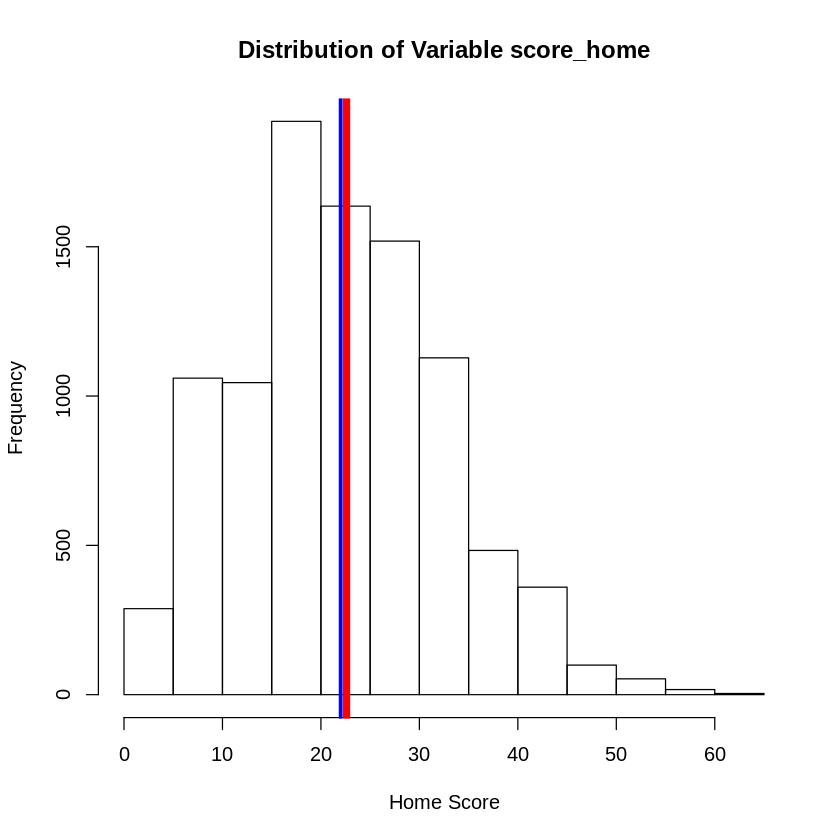

In [22]:
#Calculate mean and median to add to histogram
mean_hist_home = mean(numeric_sb_era$score_home)
median_hist_home = median(numeric_sb_era$score_home)

## Histogram of the score_home variable
hist(numeric_sb_era$score_home, main = "Distribution of Variable score_home", xlab = "Home Score")
abline(v = mean_hist_home, col = "red", lwd = 6)
abline(v = median_hist_home, col = "blue", lwd = 3)

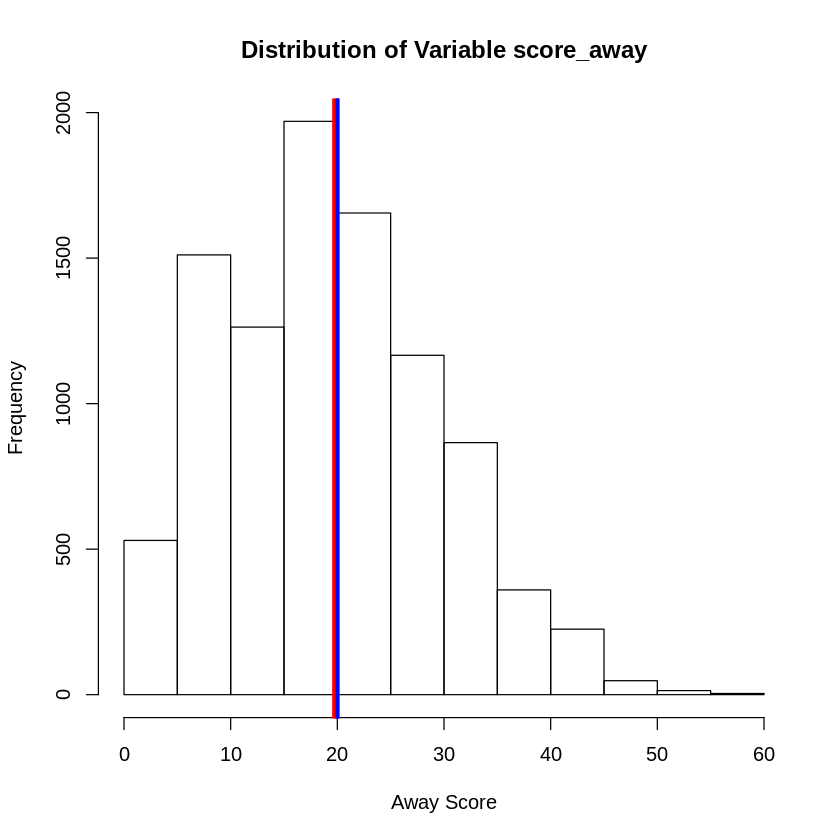

In [23]:
#Calculate mean and median to add to histogram
mean_hist_away = mean(numeric_sb_era$score_away)
median_hist_away = median(numeric_sb_era$score_away)

## Histogram of the score_away variable
hist(numeric_sb_era$score_away, main = "Distribution of Variable score_away", xlab = "Away Score")
abline(v = mean_hist_away, col = "red", lwd = 6)
abline(v = median_hist_away, col = "blue", lwd = 3)

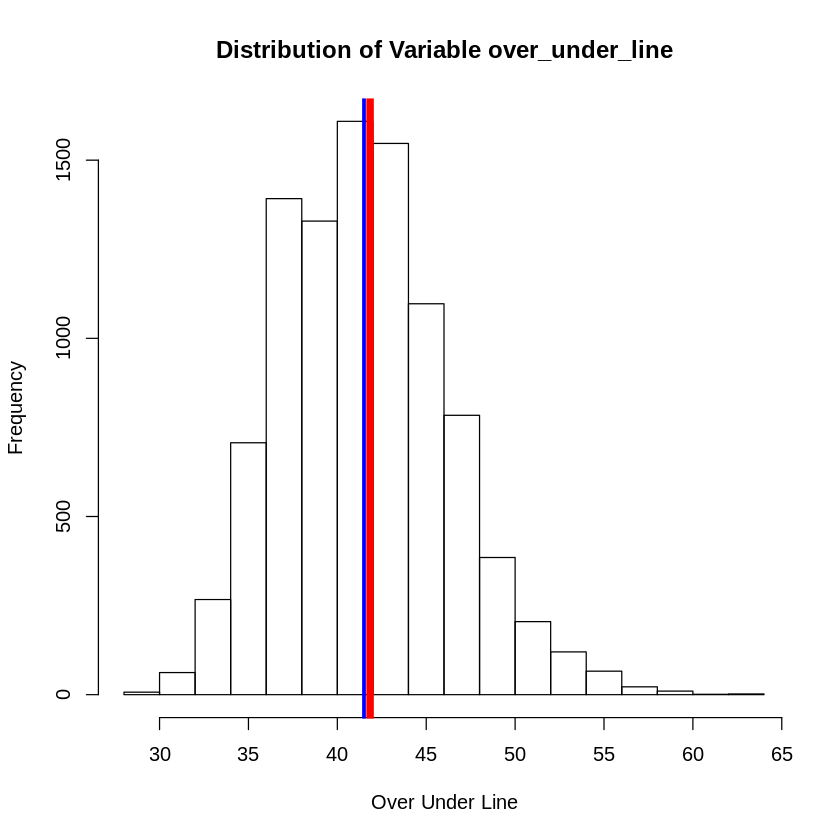

In [24]:
#Calculate mean and median to add to histogram
mean_hist_line = mean(numeric_sb_era$over_under_line)
median_hist_line = median(numeric_sb_era$over_under_line)

## Histogram of the over_under_line variable
hist(numeric_sb_era$over_under_line, main = "Distribution of Variable over_under_line", xlab = "Over Under Line")
abline(v = mean_hist_line, col = "red", lwd = 6)
abline(v = median_hist_line, col = "blue", lwd = 3)

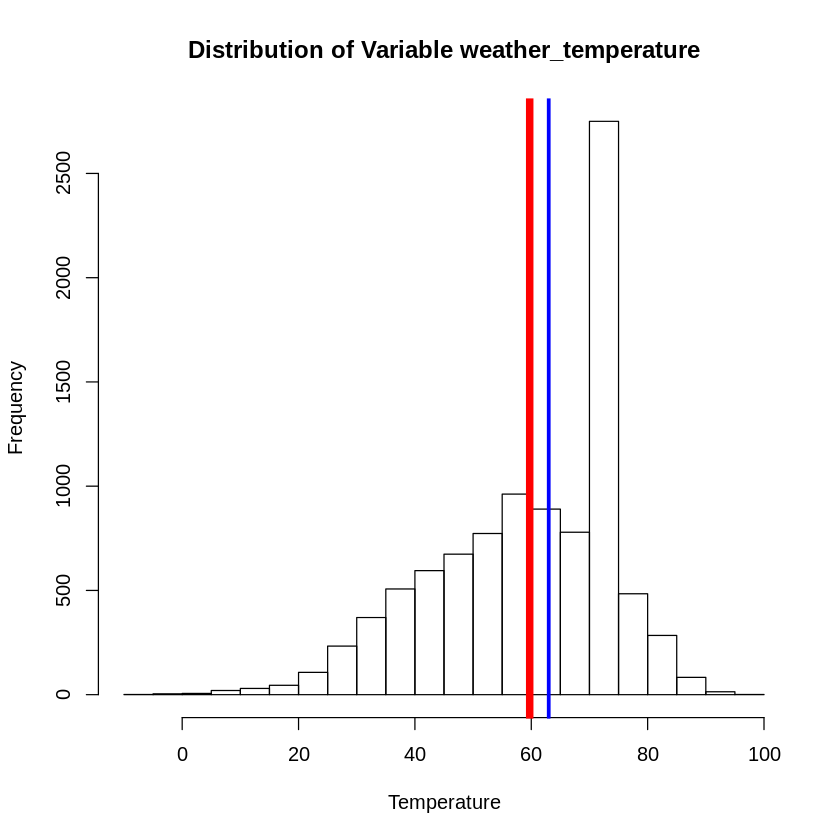

In [25]:
#Calculate mean and median to add to histogram
mean_hist_temp = mean(numeric_sb_era$weather_temperature)
median_hist_temp = median(numeric_sb_era$weather_temperature)

## Histogram of the over_under_line variable
hist(numeric_sb_era$weather_temperature, main = "Distribution of Variable weather_temperature", xlab = "Temperature")
abline(v = mean_hist_temp, col = "red", lwd = 6)
abline(v = median_hist_temp, col = "blue", lwd = 3)

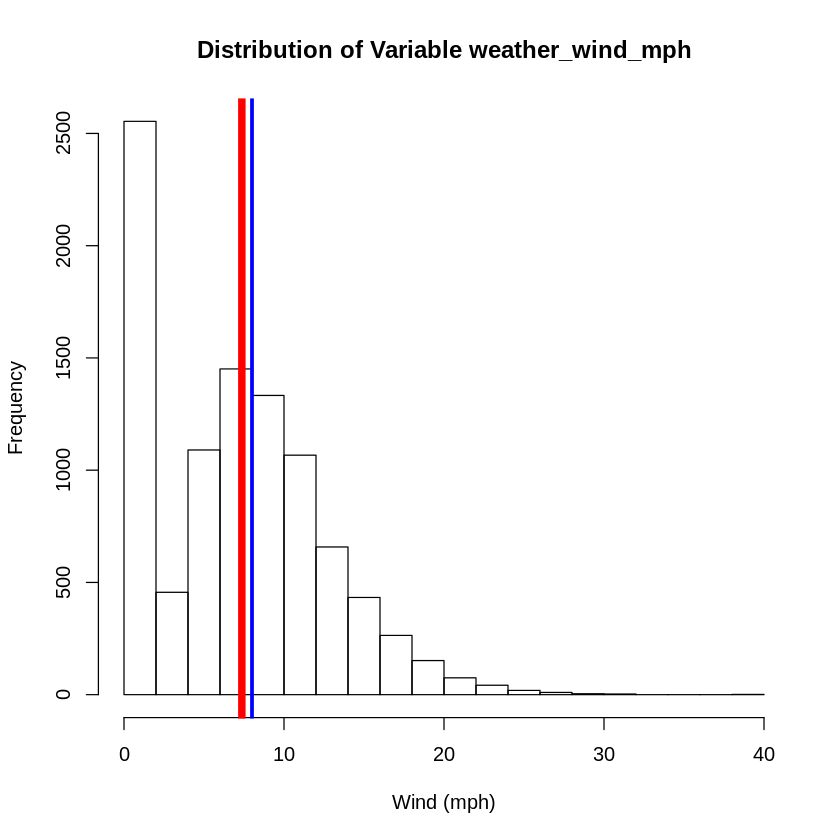

In [26]:
#Calculate mean and median to add to histogram
mean_hist_wind = mean(numeric_sb_era$weather_wind_mph)
median_hist_wind = median(numeric_sb_era$weather_wind_mph)

## Histogram of the over_under_line variable
hist(numeric_sb_era$weather_wind_mph, main = "Distribution of Variable weather_wind_mph", xlab = "Wind (mph)")
abline(v = mean_hist_wind, col = "red", lwd = 6)
abline(v = median_hist_wind, col = "blue", lwd = 3)

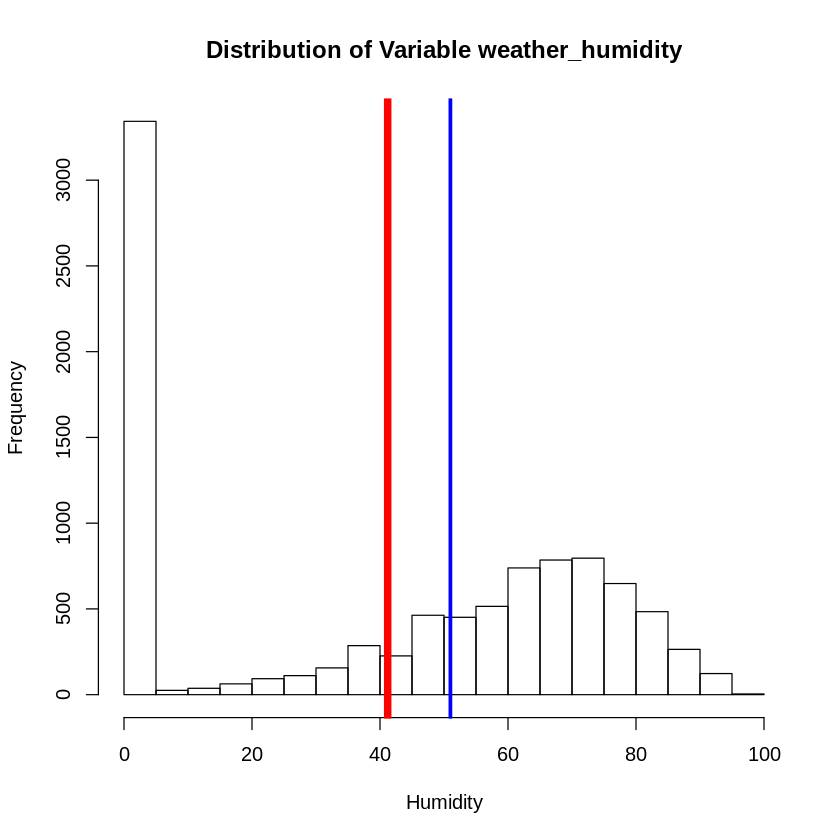

In [27]:
#Calculate mean and median to add to histogram
mean_hist_hum = mean(numeric_sb_era$weather_humidity)
median_hist_hum = median(numeric_sb_era$weather_humidity)

## Histogram of the weather_humidity variable
hist(numeric_sb_era$weather_humidity, main = "Distribution of Variable weather_humidity", xlab = "Humidity")
abline(v = mean_hist_hum, col = "red", lwd = 6)
abline(v = median_hist_hum, col = "blue", lwd = 3)

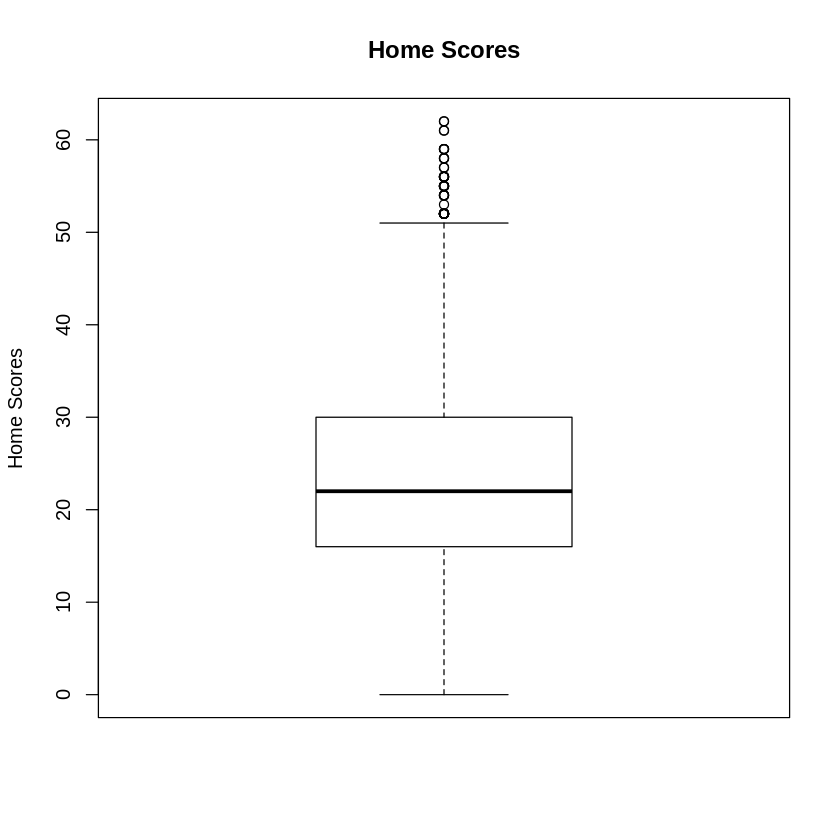

In [28]:
boxplot(numeric_sb_era$score_home, data = numeric_sb_era, main="Home Scores", ylab="Home Scores")

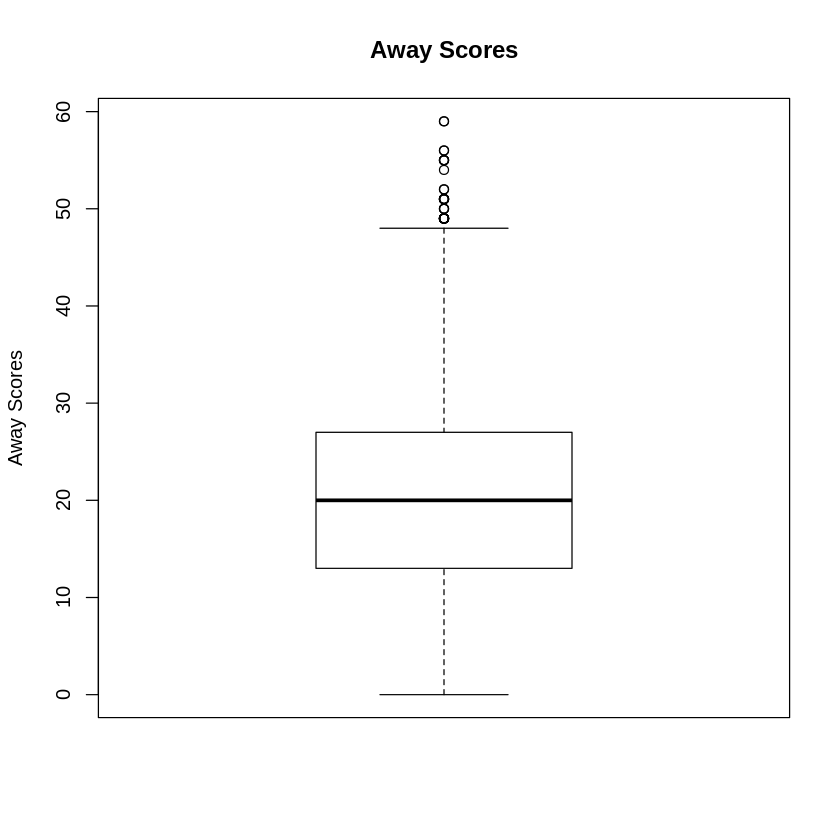

In [29]:
boxplot(numeric_sb_era$score_away, data = numeric_sb_era, main="Away Scores", ylab="Away Scores")

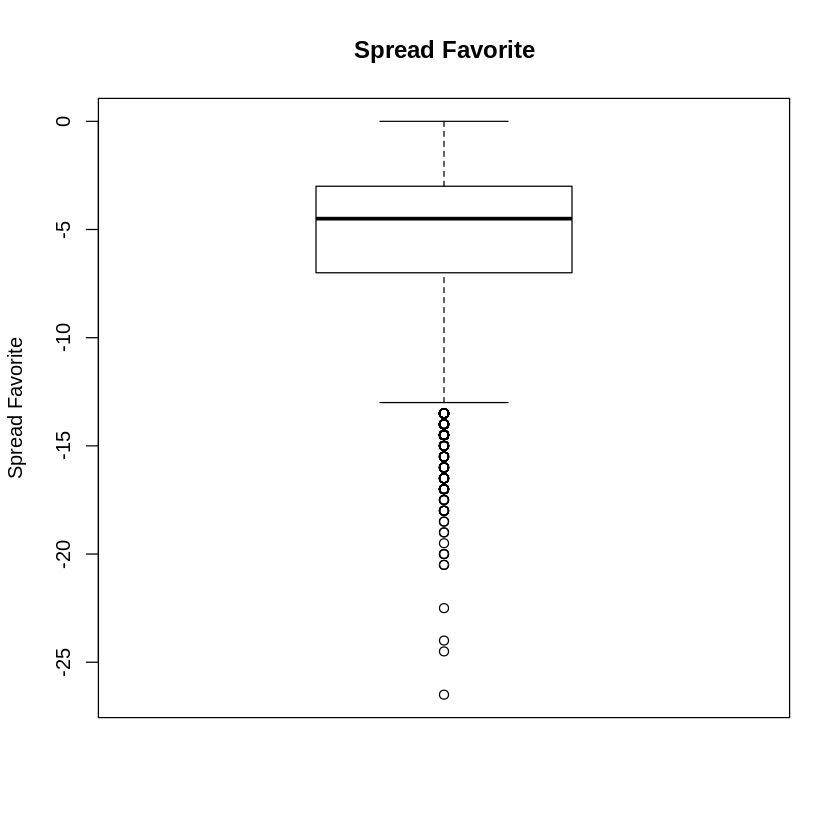

In [30]:
boxplot(numeric_sb_era$spread_favorite, data = numeric_sb_era, main="Spread Favorite", ylab="Spread Favorite")

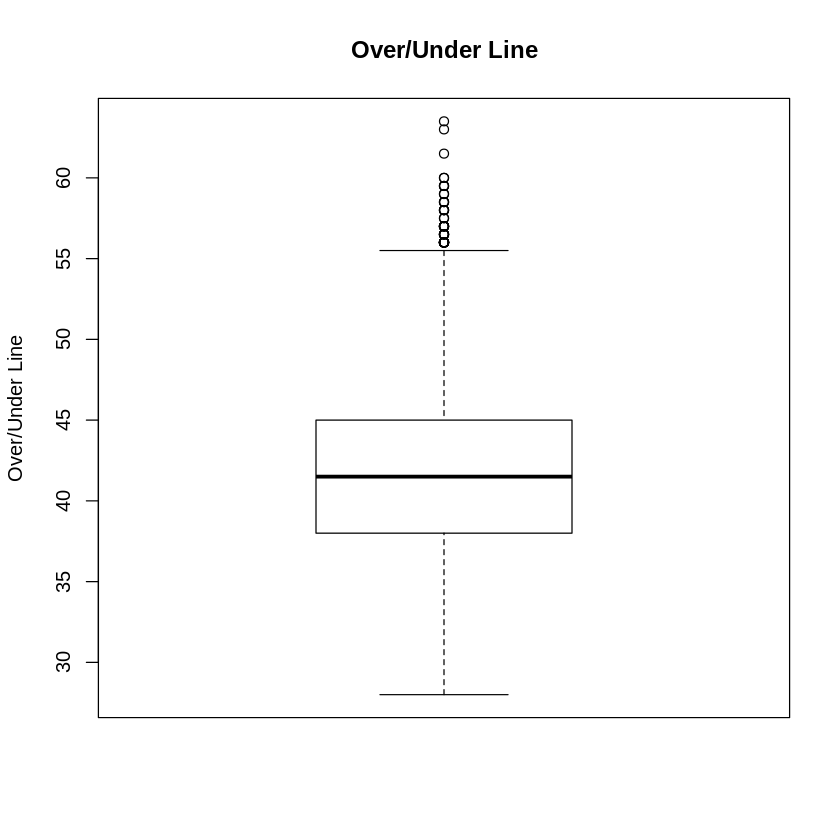

In [31]:
boxplot(numeric_sb_era$over_under_line, data = numeric_sb_era, main="Over/Under Line", ylab="Over/Under Line")

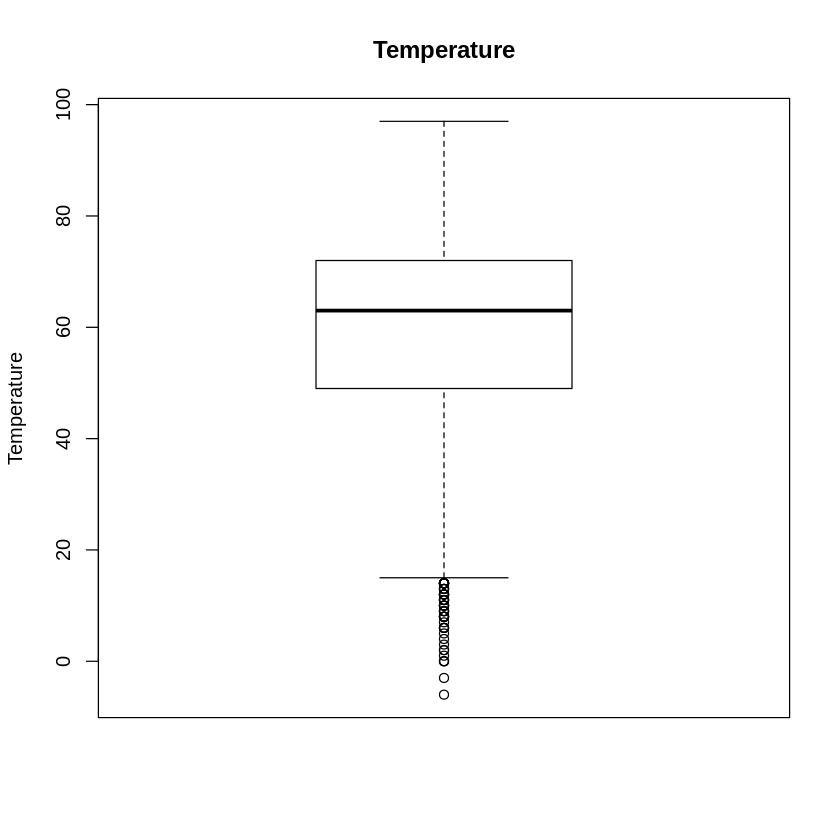

In [32]:
boxplot(numeric_sb_era$weather_temperature, data = numeric_sb_era, main="Temperature", ylab="Temperature")

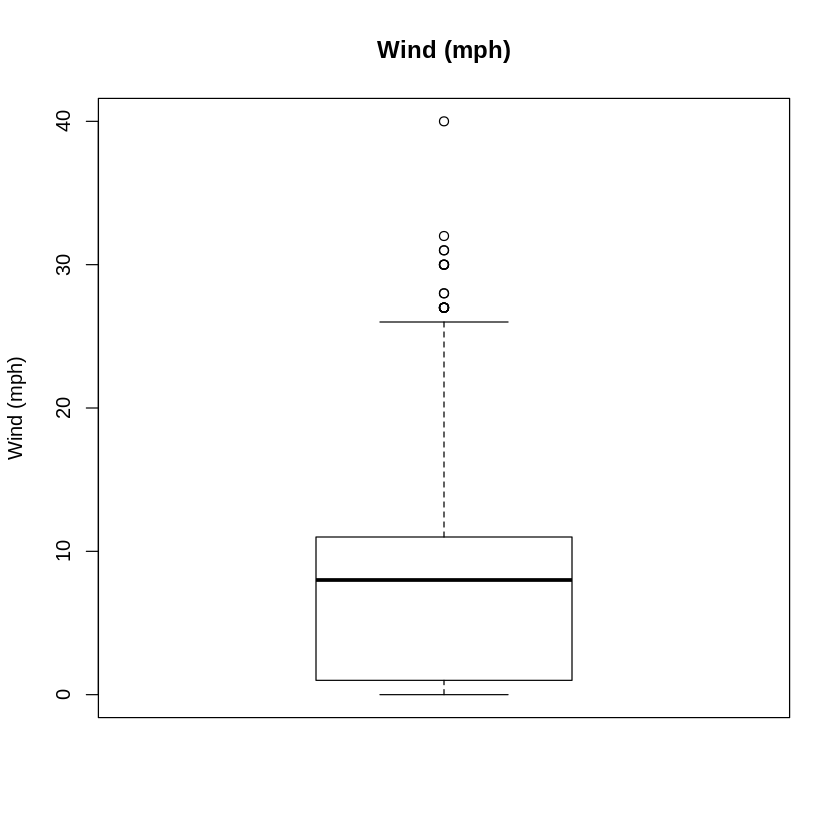

In [33]:
boxplot(numeric_sb_era$weather_wind_mph, data = numeric_sb_era, main="Wind (mph)", ylab="Wind (mph)")

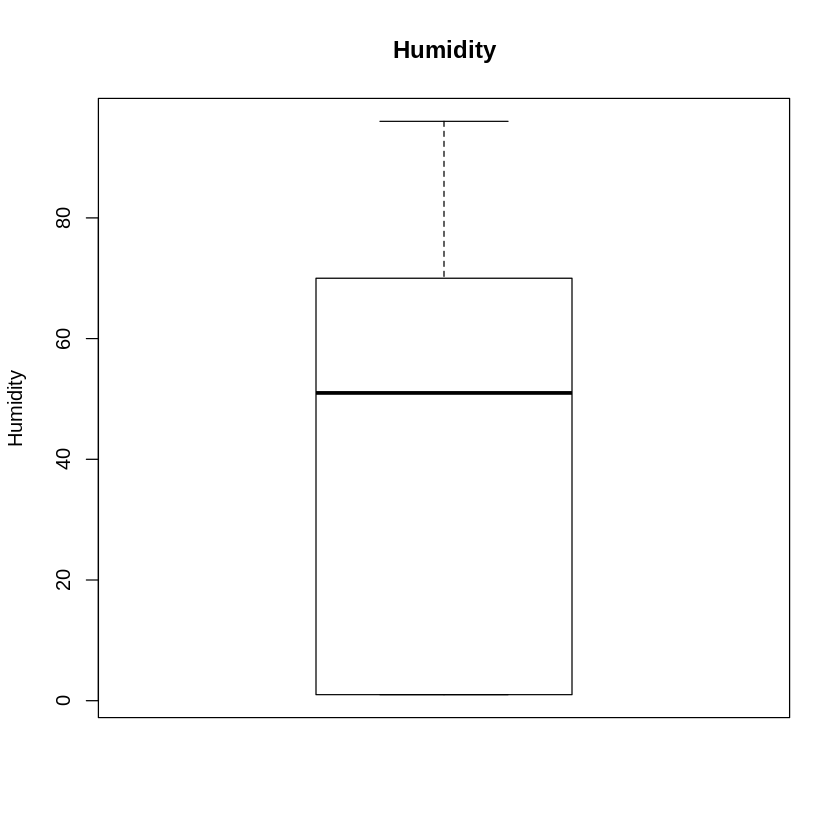

In [34]:
boxplot(numeric_sb_era$weather_humidity, data = numeric_sb_era, main="Humidity", ylab="Humidity")

### Correlation Matrix <a name="cormat"></a>

Now that we have generated some histograms and box and whisker plots, lets try to take a look at any correlations between our variables.

In [35]:
## Correlation matrix of the numeric_nfl_df
library(reshape2)

cormat <- cor(numeric_sb_era)
melted_cormat <- melt(cormat)
head(melted_cormat)


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



Var1,Var2,value
score_home,score_home,1.00000000
score_away,score_home,-0.02086546
spread_favorite,score_home,-0.14191295
over_under_line,score_home,0.20702762
weather_temperature,score_home,-0.01026509
weather_wind_mph,score_home,-0.06151897


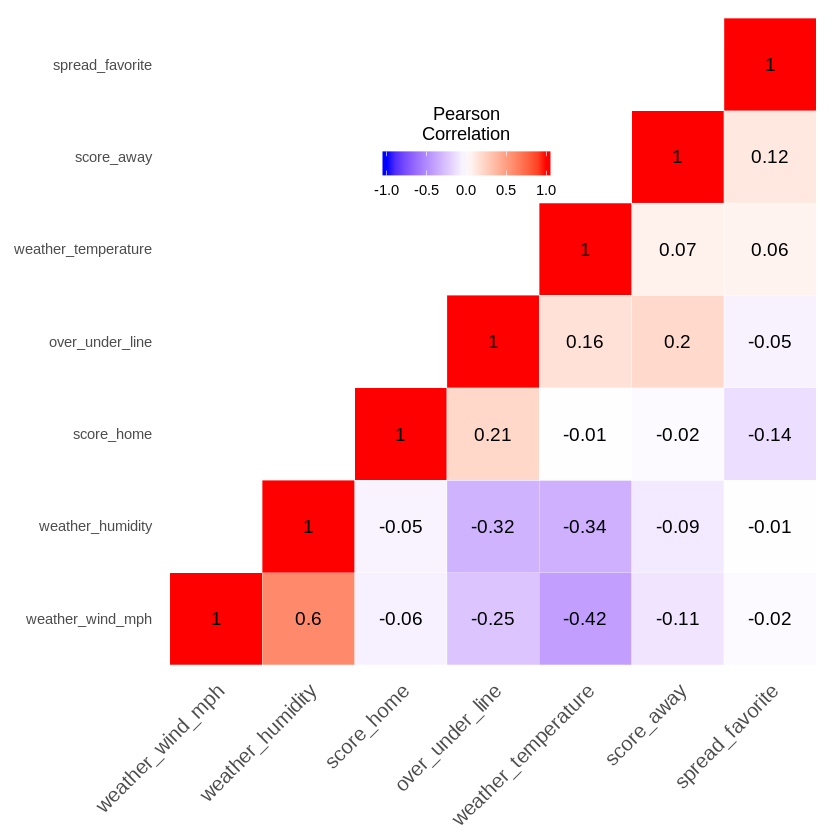

In [36]:
library(ggplot2)

reorder_cormat <- function(cormat){
# Use correlation between variables as distance
dd <- as.dist((1-cormat)/2)
hc <- hclust(dd)
cormat <-cormat[hc$order, hc$order]
}

# Get lower triangle of the correlation matrix
get_lower_tri<-function(cormat){
    cormat[upper.tri(cormat)] <- NA
    return(cormat)
  }
  # Get upper triangle of the correlation matrix
get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }

# Reorder the correlation matrix
cormat <- reorder_cormat(cormat)
upper_tri <- get_upper_tri(cormat)
# Melt the correlation matrix
melted_cormat <- melt(upper_tri, na.rm = TRUE)
# Create a ggheatmap
ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
    name="Pearson\nCorrelation") +
  theme_minimal()+ # minimal theme
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
 coord_fixed()

ggheatmap + 
geom_text(aes(Var2, Var1, label = round(value, 2)), color = "black", size = 4) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.justification = c(1, 0),
  legend.position = c(0.6, 0.7),
  legend.direction = "horizontal")+
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))

## Initial Conclusions <a name="conclusions"></a>

1.	After the first two milestones, we spoke briefly about refining our question. Ultimately, what we want to look at is if we can use NFL betting data (along with potentially other data sources, as explained in the Univariate Analysis notebook) to predict with some accuracy the outcome of the games. Our betting data also includes weather data and we are looking at incorporating data from FiveThrityEight which gives a probability of winning to each team. With all of this we’re hoping to be able to answer broadly “can you predict the outcome of an NFL game?”
2.	Not many variables within our initial data set are highly correlated, strangely enough. The most highly correlated ones are the weather variables and they tend to be correlated with each other. We’ll need to investigate further to see if there is a subset of our data we can use to produce better correlations or if there is an additional data source we need to pull in order to get stronger or more robust relationships
3.	There are several records that have several nulls across all the variables. We’re still assessing how much missing information there is, but we know for sure that some records are missing information on the weather during the game, the elevation of the stadium, and the betting information. We’re working on figuring out when we can fill in the data from an outside source, when imputing the data would be appropriate, and when we should probably just remove the record entirely
4.	We still have some exploratory analysis that we aim to do over the next two weeks or so and that will hopefully help us find some good relationships within our data that we can start building our model.
